# Lab 6 - knowledge graph based recommendations

## Lab preparation

 * download and extract the dataset: https://www.aicrowd.com/challenges/spotify-million-playlist-dataset-challenge
 * [optional] Create python virtual environment
 `python3 -m venv ./recsyslab6`
 * zinstall needed libraries:
 `pip install numpy pandas pykeen tqdm seaborn`

## Part 1 - Data preparation and preprocessing

In [54]:
import json
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import random

from pykeen.models import TransE, TransH, TransR, RESCAL
from pykeen.pipeline import pipeline
from pykeen.utils import resolve_device
from pykeen.predict import predict_target
from pykeen.triples import TriplesFactory

In [55]:
# configure the Spotify dataset
PATH = "spotify_million_playlist_dataset/data"
SAMPLING_RATIO = 0.01
FILENAMES = random.sample(
    [f"mpd.slice.{1000*i}-{1000*i+999}.json" for i in range(1000)],
    int(SAMPLING_RATIO * 1000),
)

In [56]:
# Playlsit parsing functions
def get_id(uri):
    return uri.split(":")[-1]


def parse_playlist(playlist):
    name = playlist["name"]
    tracks = [get_id(t["track_uri"]) for t in playlist["tracks"]]
    tracks_to_artists = {
        (get_id(t["track_uri"]), get_id(t["artist_uri"])) for t in playlist["tracks"]
    }
    tracks_to_albums = {
        (get_id(t["track_uri"]), get_id(t["album_uri"])) for t in playlist["tracks"]
    }
    albums_to_artists = {
        (get_id(t["album_uri"]), get_id(t["artist_uri"])) for t in playlist["tracks"]
    }
    return name, tracks, tracks_to_artists, tracks_to_albums, albums_to_artists

In [57]:
# parsing
playlists = []
tracks = set()
tracks_to_artists = set()
tracks_to_albums = set()
albums_to_artists = set()

for filename in tqdm(FILENAMES):
    with open(f"{PATH}/{filename}") as mpd_chunk:
        for playlist in json.loads(mpd_chunk.read())["playlists"]:
            a, b, c, d, e = parse_playlist(playlist)
            playlists.append(b)
            tracks.update(set(b))
            tracks_to_artists.update(c)
            tracks_to_albums.update(d)
            albums_to_artists.update(e)

print(
    f"Got: {len(playlists):,} playlists; {len(tracks):,} tracks; {len({x[1] for x in tracks_to_albums}):,} albums; {len({x[1] for x in tracks_to_artists}):,} artists"
)

100%|██████████| 10/10 [00:02<00:00,  4.18it/s]

Got: 10,000 playlists; 173,427 tracks; 83,264 albums; 36,210 artists


In [58]:
# for the test set we consider playlist that only consist of songs that also appear in the training set at least once
tracks_counter = {}
for p in tqdm(playlists):
    for t in p:
        if t in tracks_counter:
            tracks_counter[t] += 1
        else:
            tracks_counter[t] = 1

playlists_with_only_non_unique_tracks = []
for i in tqdm(range(len((playlists)))):
    p = playlists[i]
    if all([tracks_counter[t] > 1 for t in p]):
        playlists_with_only_non_unique_tracks.append(i)

# test set - 10%
test_playlist_ids = random.sample(
    playlists_with_only_non_unique_tracks, int(SAMPLING_RATIO * 100_000)
)
# training set - 90%
test_ids_sorted = sorted(test_playlist_ids)
test_i = 0
train_playlist_ids = []
i = 0
while i < len(playlists):
    if test_i < len(test_ids_sorted) and test_ids_sorted[test_i] == i:
        test_i += 1
    else:
        train_playlist_ids.append(i)
    i += 1

train_playlists = [playlists[i] for i in train_playlist_ids]
test_playlists = [playlists[i] for i in test_playlist_ids]

print(f"train dataset: {len(train_playlists):,}; test dataset: {len(test_playlists):,}")

100%|██████████| 10000/10000 [00:00<00:00, 126583.05it/s]

train dataset: 9,000; test dataset: 1,000


## Part 2 - building and evalulating the model

### Relationships in the dataset:
![image of relationships in the dataset](relations.svg)

In [59]:
# building the set of relationships
# you can delete some elements of `relations` list
relations = ["follows", "authored_by", "in_album", "authored"]
triples = []

# song -> author
if "authored_by" in relations:
    for track, artist in tqdm(tracks_to_artists):
        triples.append((track, "authored_by", artist))

# song -> artist
if "in_album" in relations:
    for track, album in tqdm(tracks_to_albums):
        triples.append((track, "in_album", album))

# artist -> album
if "authored" in relations:
    for album, artist in tqdm(albums_to_artists):
        triples.append((artist, "authored", album))

# song -> song
if "follows" in relations:
    for playlist in tqdm(train_playlists):
        for i in range(len(playlist) - 1):
            triples.append((playlist[i], "follows", playlist[i + 1]))

num_entities = len(triples)
num_relations = len(relations)

print(f"Got {num_relations} relations with total of {num_entities:,} entries")

100%|██████████| 9000/9000 [00:00<00:00, 109756.71it/s]

Got 4 relations with total of 1,049,608 entries


In [60]:
# training
tf = TriplesFactory.from_labeled_triples(np.array(triples))
# disproportion to get scores quickly
# for better results it's worthy to use 80/10/10 split
training, testing, validation = tf.split([0.8, 0.1, 0.1])

pipeline_result = pipeline(
    training=training,
    testing=testing,
    validation=validation,
    model=TransE,  # the simplest, the fastest and the worst model; other options: TransH, TransR, RESCAL, other
    epochs=20,
    device=resolve_device(),
)

INFO:pykeen.triples.splitting:done splitting triples to groups of sizes [539664, 99754, 99755]
INFO:pykeen.pipeline.api:Using device: cuda


Training epochs on cuda:0:   0%|          | 0/20 [00:00<?, ?epoch/s]

Training batches on cuda:0:   0%|          | 0/3118 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/3118 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/3118 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/3118 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/3118 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/3118 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/3118 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/3118 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/3118 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/3118 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/3118 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/3118 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/3118 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/3118 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/3118 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/3118 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/3118 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/3118 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/3118 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/3118 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Starting batch_size search for evaluation now...
C:\Users\piotr\AppData\Local\Programs\Python\Python310\lib\site-packages\pykeen\utils.py:545: RuntimeWarning: overflow encountered in scalar add
  return sum(
INFO:pykeen.evaluation.evaluator:Concluded batch_size search with batch_size=512.


Evaluating on cuda:0:   0%|          | 0.00/99.8k [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 720.28s seconds


<Axes: title={'center': 'Losses Plot'}, xlabel='Epoch', ylabel='marginranking Loss'>

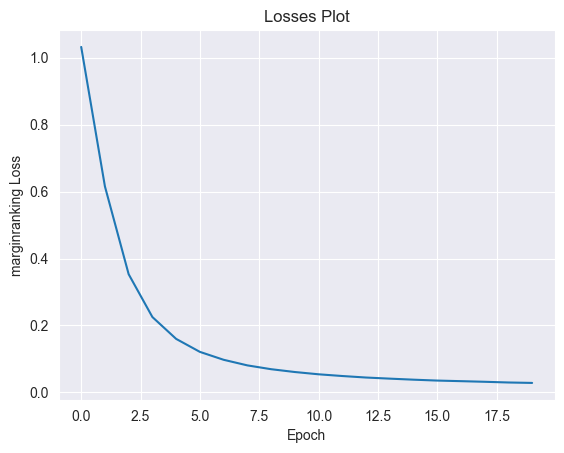

In [61]:
# rough estimate of model quality
pipeline_result.plot_losses()

In [75]:
# returning model predictions
def predict_next_tracks(track_id: str, k: int) -> list[str]:
    return (
        predict_target(
            model=pipeline_result.model,
            head=track_id,
            relation="follows",
            triples_factory=pipeline_result.training,
        )
        .df[:k]["tail_label"]
        .to_list()
    )

In [76]:
# precision and recall
def precision(prediction: list[str], actual_tracks: list[str]) -> float:
    return len(set(prediction) & set(actual_tracks)) / len(actual_tracks)


def recall(prediction: list[str], actual_tracks: list[str]) -> float:
    return len(set(prediction) & set(actual_tracks)) / len(prediction)

In [ ]:
# remove the playlists that are too short
long_enough_test_playlists = [p for p in test_playlists if len(p) >= 10]
# we predict on elements from 0 to `cutoff_idx` to get the next ones
cutoff_idx = 4

# number of elements to predict
k = 20

In [85]:
predictions = []
actual_tracks = []
for i, playlist in enumerate(long_enough_test_playlists):
    if i % 100 == 0:
        print(f"calculating prediction for iteration {i}")
    predictions.append(predict_next_tracks(playlist[cutoff_idx], k))
    actual_tracks.append(playlist[cutoff_idx : cutoff_idx + k])

calculating prediction for iteration 0
calculating prediction for iteration 100
calculating prediction for iteration 200
calculating prediction for iteration 300
calculating prediction for iteration 400
calculating prediction for iteration 500
calculating prediction for iteration 600
calculating prediction for iteration 700
calculating prediction for iteration 800


In [86]:
precisions = [precision(p, a) for p, a in zip(predictions, actual_tracks)]
recalls = [recall(p, a) for p, a in zip(predictions, actual_tracks)]

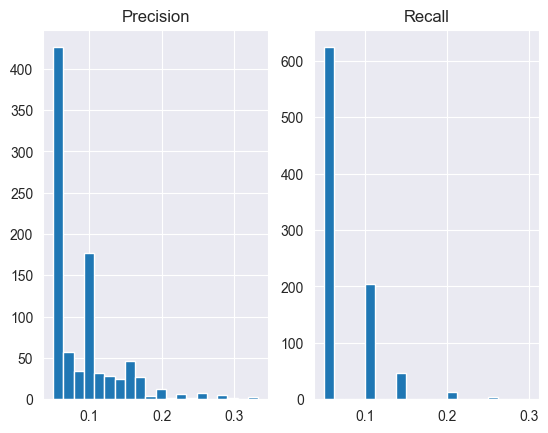

In [87]:
# histogram
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.hist(precisions, bins=20)
ax1.set_title("Precision")
ax2.hist(recalls, bins=20)
ax2.set_title("Recall")
plt.show()

## Part 3 - comparing different methods of recommendation

W części 2. zbudowaliśmy zbiór trójek relacji, wytrenowaliśmy jeden model, zaimplementowaliśmy (prostą) metodę generującą rekomendacje na podstawie predykcji modelu i w końcu zaimplementowaliśmy dwie metryki do porównania jakości tych rekomendacji.

W części 3. Twoim zadaniem jest przetestować trzy różne podejścia do jednego z kroków:
1. Porównaj trzy różne modele spośród dostępnych w bibliotece PyKeen: https://pykeen.readthedocs.io/en/stable/reference/models.html#classes
   * jeden model translacyjny (np. TransE, TransH, TransR)
   * jeden model faktoryzacyjny (np. RESCAL)
   * jeden dowolny model niewybrany w poprzednich punktach
2. Porównaj trzy metody budowania grafu wiedzy:
   * graf zawierający relacje wszystkich czterech typów
   * graf zawierający tylko relacje typu `follows` (czyli między kolejnymi utworami w playliście)
   * graf zawierający relacje wybranych przez Ciebie dwóch lub trzech typów (czyli krok pośredni między powyższymi punktami)
3. Porównaj trzy metody generowania rekomendacji na podstawie elementów zwróconych przez `predict_target()` (ta metoda zwraca m. in. score'y każdego z proponowanych elementów, co może okazać się pomocne):
   * metoda opierająca się tylko na predykcji dla ostatniego znanego elementu w playliście
   * dwie wymyślone przez Ciebie, bardziej zaawansowane metody
  
Niezależnie od tego, który z trzech powyższych scenariuszy wybierzesz - porównaj trzy wybrane przez Ciebie metody na podstawie histogramów metryk `precision@k` i `recall@k`.

In [89]:
pipeline_result_TransR = pipeline(
    training=training,
    testing=testing,
    validation=validation,
    model=TransR,
    epochs=20,
    device=resolve_device(),
)

INFO:pykeen.pipeline.api:Using device: cuda


Training epochs on cuda:0:   0%|          | 0/20 [00:00<?, ?epoch/s]

Training batches on cuda:0:   0%|          | 0/3118 [00:00<?, ?batch/s]

KeyboardInterrupt: 

In [ ]:
pipeline_result_TransH = pipeline(
    training=training,
    testing=testing,
    validation=validation,
    model=TransH,
    epochs=20,
    device=resolve_device(),
)

In [ ]:
pipeline_result_RESCAL = pipeline(
    training=training,
    testing=testing,
    validation=validation,
    model=RESCAL,
    epochs=20,
    device=resolve_device(),
)

In [ ]:
def predict_TransR(track_id: str, k: int) -> list[str]:
    return (
        predict_target(
            model=pipeline_result_TransR.model,
            head=track_id,
            relation="follows",
            triples_factory=pipeline_result.training,
        )
        .df[:k]["tail_label"]
        .to_list()
    )


def predict_TransH(track_id: str, k: int) -> list[str]:
    return (
        predict_target(
            model=pipeline_result_TransH.model,
            head=track_id,
            relation="follows",
            triples_factory=pipeline_result.training,
        )
        .df[:k]["tail_label"]
        .to_list()
    )


def predict_RESCAL(track_id: str, k: int) -> list[str]:
    return (
        predict_target(
            model=pipeline_result_RESCAL.model,
            head=track_id,
            relation="follows",
            triples_factory=pipeline_result.training,
        )
        .df[:k]["tail_label"]
        .to_list()
    )

In [ ]:
predictions_TransR = []
predictions_TransH = []
predictions_RESCAL = []
actual_tracks = [playlist[cutoff_idx : cutoff_idx + k]]
for i, playlist in enumerate(long_enough_test_playlists):
    if i % 100 == 0:
        print(f"calculating prediction for iteration {i}")
    predictions_TransR.append(predict_TransR(playlist[cutoff_idx], k))
    predictions_TransH.append(predict_TransH(playlist[cutoff_idx], k))
    predictions_RESCAL.append(predict_RESCAL(playlist[cutoff_idx], k))

In [ ]:
precisions_TransR = [precision(p, a) for p, a in zip(predictions_TransR, actual_tracks)]
precisions_TransH = [precision(p, a) for p, a in zip(predictions_TransH, actual_tracks)]
precisions_RESCAL = [precision(p, a) for p, a in zip(predictions_RESCAL, actual_tracks)]
recalls_TransR = [recall(p, a) for p, a in zip(predictions_TransR, actual_tracks)]
recalls_TransH = [recall(p, a) for p, a in zip(predictions_TransH, actual_tracks)]
recalls_RESCAL = [recall(p, a) for p, a in zip(predictions_RESCAL, actual_tracks)]

In [ ]:
# histogram
fig, ax = plt.subplots(3, 2, figsize=(21, 14))

ax[0][0].hist(precisions, bins=20)
ax[0][0].set_title("Precision TransR")
ax[0][1].hist(recalls, bins=20)
ax[0][1].set_title("Recall TransR")
ax[1][0].hist(precisions, bins=20)
ax[1][0].set_title("Precision TransH")
ax[1][1].hist(recalls, bins=20)
ax[1][1].set_title("Recall TransH")
ax[2][0].hist(precisions, bins=20)
ax[2][0].set_title("Precision RESCAL")
ax[2][1].hist(recalls, bins=20)
ax[2][1].set_title("Recall RESCAL")
plt.show()